In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import iris
import iris.quickplot as qplt
import iris.plot as iplt
import json
import cftime
from itertools import product
from cftime import DatetimeNoLeap
import esmvalcore.preprocessor
import xesmf as xe
import warnings
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.interpolate import interp1d
from sklearn import metrics
import dask
from tqdm import tqdm
from nc_processing import calc_spatial_mean
from mpl_axes_aligner import align
#sns.set()

from xmip.preprocessing import rename_cmip6
import matplotlib.path as mpath

def read_in(dir, ocean = False):
    files = []
    for x in os.listdir(dir):
        files.append(dir + x)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = rename_cmip6(xr.open_mfdataset(files, use_cftime=True, engine='netcdf4'))
    return ds

def read_in_ens_mean(dirs, ocean = False, zonal_mean=False, max_ens_members=False):
    """ returns (1) the ensemble mean dataset, and (2) the number of ensemble members """
    
    files = []
    if max_ens_members:
        dirs = dirs[0:max_ens_members]
    for dir in dirs:
        for x in os.listdir(dir):
            if '.nc' in x:
                files.append(dir + x)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        #print(files)
        ds = rename_cmip6(xr.open_mfdataset(files, use_cftime=True, concat_dim='ensemble',combine='nested'))
        n_ens = len(ds.ensemble) 
        ds = ds.mean(dim='ensemble')
        if zonal_mean:
            ds = ds.mean(dim='x')
        ds['number_ens_mems_meaned'] = n_ens
    return ds

def get_gmst(ds):
    return calc_spatial_mean(ds.tas.mean(dim="time"), lon_name="x", lat_name="y").values

def get_dirs(var, model, scenario, table='Amon', max5=True, max10=False):
    if scenario == 'ARISE':
        dirs = glob.glob('/badc/deposited2022/arise/data/ARISE/MOHC/UKESM1-0-LL/arise-sai-1p5/*/{t}/{v}/*/*/'.format(
            t=table, v=var))
    else:
        dirs = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/*/{t}/{v}/*/latest/'.format(
            m=model, s=scenario, t=table, v=var))
    #weird_jasmin_vars = ['rlds', 'rlus'] 
    #if model == 'UKESM1-0-LL': # weird error on opening several files, perhaps corrupted?
    #    if var == 'rlds':
    #        dirs = dirs[0:2]
    #    if var == 'rlus':
    #        dirs = dirs[1:]
    if max5:
        dirs2 = []
        for x in dirs:
            for y in ['r1i', 'r2i', 'r3i', 'r4i', 'r6i']: #avoid member 5 as there are issues opening for some vars
                if y in x:
                    dirs2.append(x)
        return dirs2
    if max10:
        return dirs[0:10]
    else:
        return dirs



def get_all_vars_arctic_monthly(vars, model, scenario,
                                min_lat=70, max_lat=90,
                                min_year="2080", max_year="2100"):
    ds_list = []
    for var in tqdm(vars):
        print(var)
        ds = read_in_ens_mean(get_dirs(var, model, scenario, table='Amon'),
                              ocean=False, zonal_mean=True,
                              max_ens_members=5)
        ds_list.append(ds)
    
    DS = xr.merge(ds_list, compat='override')
    
    ## take an arctic spatial mean:
    DS = DS.sel(y=slice(min_lat, max_lat))
    weights = np.cos(np.deg2rad(DS.y))
    weights.name = "weights"
    DS_weighted = DS.weighted(weights)
    DS_smean = DS_weighted.mean("y")
    
    ## take late-century monthly time-mean
    DS_stmean = DS_smean.sel(time=slice(min_year, max_year)).groupby("time.month").mean(dim="time")
    
    return DS_stmean

def get_surface_area_north_of_lat(min_lat):
    path = '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/fx/areacella/gn/latest/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc'
    areacella = rename_cmip6(xr.open_dataset(path))
    out = areacella.sel(y=slice(min_lat, 90.1)).sum(dim=['x', 'y']).areacella.values*1
    return out


##### SETTINGS
model = 'UKESM1-0-LL'
scenarios = ['G6sulfur', 'G6solar', 'ssp245', 'ssp585', 'ARISE']
min_lat, max_lat = 70, 90
min_year_late_cent, max_year_late_cent = "2050", "2070"
scenarios.reverse()
#do_preprocess = True

In [2]:

rad_flux_vars_surface = ['rsds', 'rsus', 'rlds', 'rlus', 'rsdscs', 'rldscs']
# all radiative vars at surface

rad_flux_vars_TOA = ['rsdt', 'rsut', 'rlut']
# all radiative vars at top-of-atmosphere

heat_flux_vars_surface = ['hfls', 'hfss'] 
# surface upward latent heat flux and surface upward sensible heat flux

PE_vars = ['evspsbl', 'pr']

AHT_vars = ['tas'] + rad_flux_vars_surface + rad_flux_vars_TOA + heat_flux_vars_surface + PE_vars



In [3]:

### preproces, 20 mins?:
do_preprocess = False

if do_preprocess:
    for scen in scenarios:
        ds = get_all_vars_arctic_monthly(vars=AHT_vars, model=model,
                                          scenario=scen,
                                          min_lat=min_lat, max_lat=max_lat,
                                          min_year=min_year_late_cent, max_year=max_year_late_cent)
        ds = ds.compute()
        ds.to_netcdf('Preprocessed_data/UKESM_all_vars/{s}_{l}_{m}.nc'.format(
            s=scen, l=str(min_lat), m=model))


In [4]:
"""
#also preprocess a present day version of ssp245:
scen = 'ssp245'
min_year_pd = '2015'
max_year_pd = '2030'
ds = get_all_vars_arctic_monthly(vars=AHT_vars, model=model,
                                          scenario=scen,
                                          min_lat=min_lat, max_lat=max_lat,
                                          min_year=min_year_pd, max_year=max_year_pd)
ds = ds.compute()
ds.to_netcdf('Preprocessed_data/UKESM_all_vars/{s}_{y1}-{y2}_{l}_{m}.nc'.format(
            s=scen, y1=min_year_pd, y2=max_year_pd, l=str(min_lat), m=model))
"""

  0%|          | 0/14 [00:00<?, ?it/s]

tas


  7%|▋         | 1/14 [00:04<01:01,  4.74s/it]

rsds


 14%|█▍        | 2/14 [00:09<00:54,  4.52s/it]

rsus


 21%|██▏       | 3/14 [00:13<00:47,  4.31s/it]

rlds


 29%|██▊       | 4/14 [00:35<01:53, 11.30s/it]

rlus


 36%|███▌      | 5/14 [00:39<01:17,  8.65s/it]

rsdscs


 43%|████▎     | 6/14 [00:42<00:54,  6.78s/it]

rldscs


 50%|█████     | 7/14 [00:45<00:38,  5.56s/it]

rsdt


 57%|█████▋    | 8/14 [00:47<00:26,  4.46s/it]

rsut


 64%|██████▍   | 9/14 [00:50<00:20,  4.04s/it]

rlut


 71%|███████▏  | 10/14 [00:54<00:15,  4.00s/it]

hfls


 79%|███████▊  | 11/14 [00:57<00:11,  3.78s/it]

hfss


 86%|████████▌ | 12/14 [01:01<00:07,  3.76s/it]

evspsbl


 93%|█████████▎| 13/14 [01:03<00:03,  3.30s/it]

pr


100%|██████████| 14/14 [01:08<00:00,  4.86s/it]


In [5]:
### read in pre-processed data (instant)
folder = 'ported'
ds_g6sulfur = xr.open_dataset('Preprocessed_data/{f}/{s}_{l}_{m}.nc'.format(
        f=folder, s='G6sulfur', l=str(min_lat), m=model))
ds_g6solar = xr.open_dataset('Preprocessed_data/{f}/{s}_{l}_{m}.nc'.format(
        f=folder, s='G6solar', l=str(min_lat), m=model))
ds_ssp245 = xr.open_dataset('Preprocessed_data/{f}/{s}_{l}_{m}.nc'.format(
        f=folder, s='ssp245', l=str(min_lat), m=model))
ds_ssp585 = xr.open_dataset('Preprocessed_data/{f}/{s}_{l}_{m}.nc'.format(
        f=folder, s='ssp585', l=str(min_lat), m=model))
ds_arise = xr.open_dataset('Preprocessed_data/{f}/{s}_{l}_{m}.nc'.format(
        f=folder, s='ARISE', l=str(min_lat), m=model))

ds_ssp245_presentday = xr.open_dataset('Preprocessed_data/UKESM_all_vars/{s}_2015-2030_{l}_{m}.nc'.format(
        f=folder, s='ssp245', l=str(min_lat), m=model))


In [6]:

# take Q as sum of energy leaving air column 
def get_Q(ds, units='W/m2'):
    
    if not units in ['W/m2', 'PW']: #check units
        print('Units must be set to either "W/m2" or "PW", default is W/m2') 
        
    ds = ds.mean('month')
    Q = (ds.rsds - ds.rsus + ds.rlds - ds.rlus - ds.hfls - ds.hfss + ds.rsut - ds.rsdt + ds.rlut)
   
    ### need to multiply by area to get these into total AHT units (PW)
    area = get_surface_area_north_of_lat(min_lat)
    unit_conversions = {'W/m2':1,
                        'PW':area/(10**15)}
    ### now split into moist and dry components. Done following Hahn et al. 2021
    ### https://www.frontiersin.org/articles/10.3389/feart.2021.710036/full
    ### we take moist energy transport as (P-E)*(latent heat of vaporisation).
    ### this neglects the latent heat of fusion for solid precip. 
    ### the dry component is then calculated as the difference between Q and moist

    L = 2.501*(10**6)# latent heat of vaporisation, assumed constant at 2.501 × 10^6 J kg−1
    Qmoist = (ds.pr - ds.evspsbl)*L 

    Q = Q*unit_conversions[units] 
    Qmoist = Qmoist*unit_conversions[units]
        
    Qdry = Q - Qmoist
    return {'Q':Q.values*1, 'Qdry':Qdry.values*1, 'Qmoist':Qmoist.values*1}

def get_monthlyQ(ds, units='W/m2'):

    if not units in ['W/m2', 'PW']: #check units
        print('Units must be set to either "W/m2" or "PW", default is W/m2') 
    
    ### need to multiply by area to get these into total AHT units (PW)
    area = get_surface_area_north_of_lat(min_lat)
    unit_conversions = {'W/m2':1,
                        'PW':area/(10**15)}
    ds['Q'] = (ds.rsds - ds.rsus + ds.rlds - ds.rlus - ds.hfls - ds.hfss + ds.rsut - ds.rsdt + ds.rlut)*unit_conversions[units] #in PW

    ### now split into moist and dry components. Done following Hahn et al. 2021
    ### https://www.frontiersin.org/articles/10.3389/feart.2021.710036/full
    ### we take moist energy transport as (P-E)*(latent heat of vaporisation).
    ### this neglects the latent heat of fusion for solid precip. 
    ### the dry component is then calculated as the difference between Q and moist

    L = 2.501*(10**6)# latent heat of vaporisation, assumed constant at 2.501 × 10^6 J kg−1
    ds['Qmoist'] = (ds.pr - ds.evspsbl)*L*unit_conversions[units] 
    ds['Qdry'] = ds['Q'] - ds['Qmoist']
    return ds

units = 'W/m2'

# add heat transport to ds's
Q_ssp245 = get_Q(ds_ssp245, units=units)
deltaQ_g6sulfur = get_Q(ds_g6sulfur - ds_ssp245, units=units)
deltaQ_g6solar = get_Q(ds_g6solar - ds_ssp245, units=units)
deltaQ_ssp585 = get_Q(ds_ssp585 - ds_ssp245, units=units)

ds_ssp245 = get_monthlyQ(ds_ssp245, units=units)    
ds_ssp585 = get_monthlyQ(ds_ssp585, units=units)    
ds_g6sulfur = get_monthlyQ(ds_g6sulfur, units=units)    
ds_g6solar = get_monthlyQ(ds_g6solar, units=units)    
ds_arise = get_monthlyQ(ds_arise, units=units) 
ds_ssp245_presentday = get_monthlyQ(ds_ssp245_presentday, units=units) 

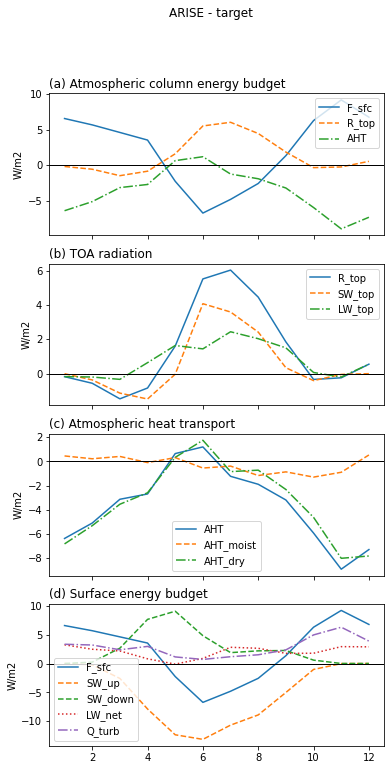

In [7]:
#### recreate the Serreze et al. 2007, Fig 3, for present day (2015-2030) 

# sign convention here: positive is energy into the atmospheric column
# i.e. at surface, up is positive, at TOA, down is positive

### choose scenario and main title
#ds = ds_ssp245_presentday.copy()
#ds = ds_ssp245 - ds_ssp245_presentday.copy()
#ds = ds_arise - ds_ssp245
ds = ds_arise - ds_ssp245_presentday
titles = ['SSP2-4.5 2015-2030', 'SSP2-4.5 (2050-2070) - (2015-2030)', 'ARISE - background', 'ARISE - target']
title = titles[3]
#path_str = 'ARISE_change_vs_background'
path_str = 'ARISE_change_vs_target'

# define new terms
Rtop = ds.rsdt - ds.rsut - ds.rlut
SWup = ds.rsus
SWdown = -ds.rsds
SWnet = ds.rsus - ds.rsds
LWnet =  ds.rlus - ds.rlds
H = ds.hfls + ds.hfss
Fsfc = SWnet + LWnet + H
AHT = ds.Q
SWtop = ds.rsdt - ds.rsut
LWtop = - ds.rlut
AHTmoist = ds.Qmoist
AHTdry = ds.Qdry

# plot 1: Rtop, Fsfc, and AHT (we assume d(Ae)/dt = 0)
df1 = pd.DataFrame({'Month':ds.month.values,
                    'F_sfc':Fsfc.values,
                    'R_top':Rtop.values,
                    'AHT':AHT.values
                   }
                 )

#plot 2: Rtop, SWtop and LWtop
df2 = pd.DataFrame({'Month':ds.month.values,
                    'R_top':Rtop.values,
                    'SW_top':SWtop.values,
                    'LW_top':LWtop.values
                   }
                 )

#plot 3: AHT, AHTmoist and AHTdry
df3 = pd.DataFrame({'Month':ds.month.values,
                    'AHT':AHT.values,
                    'AHT_moist':AHTmoist.values,
                    'AHT_dry':AHTdry.values
                   }
                 )

#plot 4: SWup, SWdown, Fsfc, H, LWnet
df4 = pd.DataFrame({'Month':ds.month.values,
                    'F_sfc':Fsfc.values,
                    'SW_up':SWup.values,
                    'SW_down':SWdown.values,
                    'LW_net':LWnet.values,
                    'Q_turb':H.values
                   }
                 )


# now plot
fig, axs = plt.subplots(nrows=4, ncols=1, figsize = (6, 12), sharex=True)

# linestyle dicts
col_ls_dicts = [{'F_sfc':'solid',
               'R_top':'dashed',
               'AHT':'dashdot'},
                
                {'R_top':'solid',
               'SW_top':'dashed',
               'LW_top':'dashdot'},
                
                {'AHT':'solid',
               'AHT_moist':'dashed',
               'AHT_dry':'dashdot'},
               
               {'F_sfc':'solid',
               'SW_up':'dashed',
               'SW_down':'dashed',
               'LW_net':'dotted',
               'Q_turb':'dashdot'}]

subtitles = ['(a) Atmospheric column energy budget',
             '(b) TOA radiation',
             '(c) Atmospheric heat transport',
             '(d) Surface energy budget']

def part_plot(df, col_ls_dict, ax, subtitle=None):
    for col in df.columns:
        if not col == 'Month':
            ax.plot(df['Month'], df[col], label=col, ls = col_ls_dict[col])
    ax.axhline(y=0, c='black', lw=1)
    if subtitle:
        ax.set_title(subtitle, loc='left')
    ax.set_ylabel('W/m2')
    ax.legend()

i=0
for df in [df1, df2, df3, df4]:
    part_plot(df=df, col_ls_dict=col_ls_dicts[i], ax=axs[i], subtitle=subtitles[i])
    i=i+1



plt.suptitle(title)

plt.savefig('Figures/After_serreze/{}_UKESM_arctic_energy_budget.jpg'.format(path_str), dpi=400)

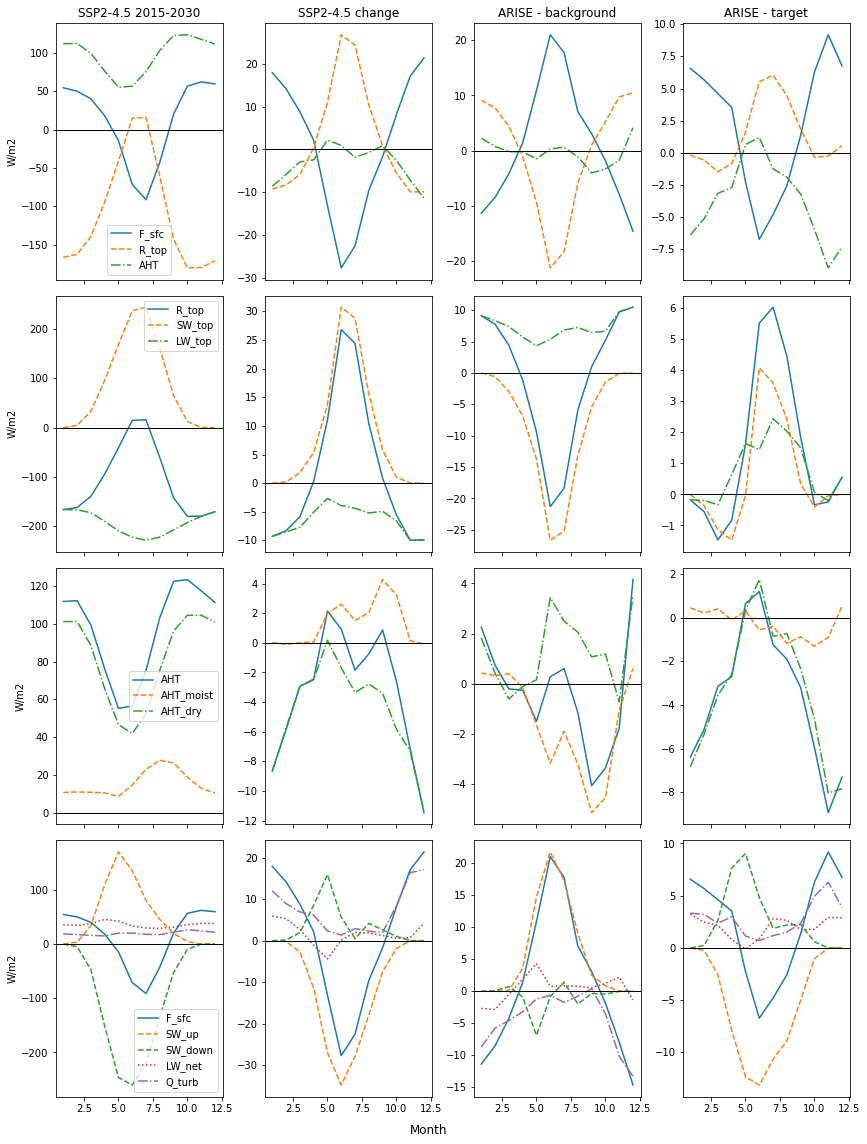

In [13]:
#### now repeat, also showing differences between scenarios

# sign convention here: positive is energy into the atmospheric column
# i.e. at surface, up is positive, at TOA, down is positive

### choose scenario and main title
dss = [ds_ssp245_presentday.copy(), 
      ds_ssp245 - ds_ssp245_presentday, 
       ds_arise - ds_ssp245, 
       ds_arise - ds_ssp245_presentday]
titles = ['SSP2-4.5 2015-2030', 
          'SSP2-4.5 change', 
          'ARISE - background', 
          'ARISE - target']

ds_dict = dict(zip(titles, dss))


fig, axs = plt.subplots(nrows=4, ncols=len(titles), figsize = (12, 16), sharex=True, sharey=False)

j=0

for title in ds_dict:

    ds = ds_dict[title].copy()
    # define new terms
    Rtop = ds.rsdt - ds.rsut - ds.rlut
    SWup = ds.rsus
    SWdown = -ds.rsds
    SWnet = ds.rsus - ds.rsds
    LWnet =  ds.rlus - ds.rlds
    H = ds.hfls + ds.hfss
    Fsfc = SWnet + LWnet + H
    AHT = ds.Q
    SWtop = ds.rsdt - ds.rsut
    LWtop = - ds.rlut
    AHTmoist = ds.Qmoist
    AHTdry = ds.Qdry
    
    # plot 1: Rtop, Fsfc, and AHT (we assume d(Ae)/dt = 0)
    df1 = pd.DataFrame({'Month':ds.month.values,
                        'F_sfc':Fsfc.values,
                        'R_top':Rtop.values,
                        'AHT':AHT.values
                       }
                     )
    
    #plot 2: Rtop, SWtop and LWtop
    df2 = pd.DataFrame({'Month':ds.month.values,
                        'R_top':Rtop.values,
                        'SW_top':SWtop.values,
                        'LW_top':LWtop.values
                       }
                     )
    
    #plot 3: AHT, AHTmoist and AHTdry
    df3 = pd.DataFrame({'Month':ds.month.values,
                        'AHT':AHT.values,
                        'AHT_moist':AHTmoist.values,
                        'AHT_dry':AHTdry.values
                       }
                     )
    
    #plot 4: SWup, SWdown, Fsfc, H, LWnet
    df4 = pd.DataFrame({'Month':ds.month.values,
                        'F_sfc':Fsfc.values,
                        'SW_up':SWup.values,
                        'SW_down':SWdown.values,
                        'LW_net':LWnet.values,
                        'Q_turb':H.values
                       }
                     )
    
    
    
    i=0
    for df in [df1, df2, df3, df4]:
        part_plot(df=df, col_ls_dict=col_ls_dicts[i], ax=axs[i,j], subtitle=None)
        i=i+1
    
    j=j+1

for j in np.arange(0, len(titles)):
    axs[0, j].set_title(titles[j])

for i in np.arange(0, 4):
    for j in np.arange(1,len(titles)):
        axs[i, j].set_ylabel('')
        axs[i, j].get_legend().remove()
 

fig.supxlabel('Month')
plt.tight_layout()
#plt.suptitle(title)

plt.savefig('Figures/After_serreze/changes_in_UKESM_arctic_energy_budget_arise.jpg'.format(title), dpi=400)

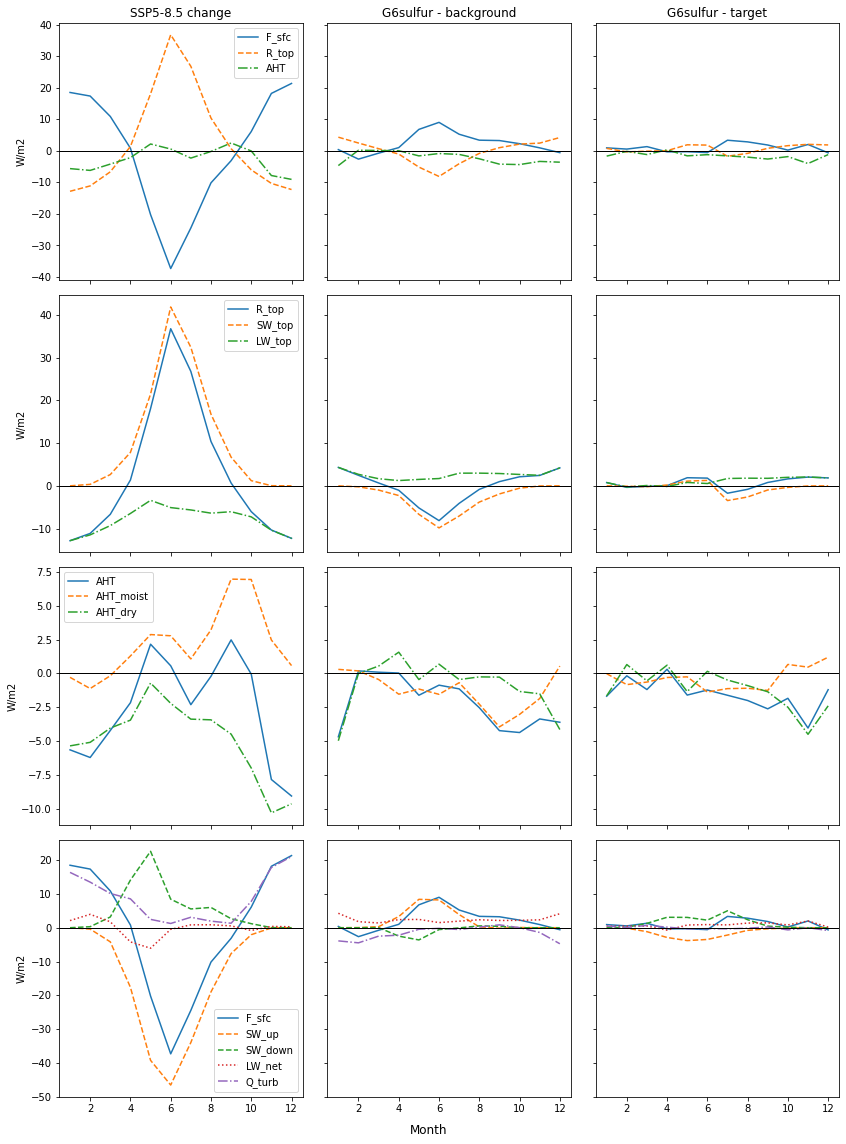

In [9]:
#### now repeat, also showing differences between scenarios

# sign convention here: positive is energy into the atmospheric column
# i.e. at surface, up is positive, at TOA, down is positive

### choose scenario and main title
#dss = [ds_ssp245_presentday.copy(), 
dss =  [ds_ssp585 - ds_ssp245_presentday, 
       ds_g6sulfur - ds_ssp585, 
       ds_g6sulfur - ds_ssp245]
#titles = ['SSP2-4.5 2015-2030', 
titles =  ['SSP5-8.5 change', 
          'G6sulfur - background', 
          'G6sulfur - target']

ds_dict = dict(zip(titles, dss))


fig, axs = plt.subplots(nrows=4, ncols=len(titles), figsize = (12, 16), sharex=True, sharey='row')

j=0

for title in ds_dict:

    ds = ds_dict[title].copy()
    # define new terms
    Rtop = ds.rsdt - ds.rsut - ds.rlut
    SWup = ds.rsus
    SWdown = -ds.rsds
    SWnet = ds.rsus - ds.rsds
    LWnet =  ds.rlus - ds.rlds
    H = ds.hfls + ds.hfss
    Fsfc = SWnet + LWnet + H
    AHT = ds.Q
    SWtop = ds.rsdt - ds.rsut
    LWtop = - ds.rlut
    AHTmoist = ds.Qmoist
    AHTdry = ds.Qdry
    
    # plot 1: Rtop, Fsfc, and AHT (we assume d(Ae)/dt = 0)
    df1 = pd.DataFrame({'Month':ds.month.values,
                        'F_sfc':Fsfc.values,
                        'R_top':Rtop.values,
                        'AHT':AHT.values
                       }
                     )
    
    #plot 2: Rtop, SWtop and LWtop
    df2 = pd.DataFrame({'Month':ds.month.values,
                        'R_top':Rtop.values,
                        'SW_top':SWtop.values,
                        'LW_top':LWtop.values
                       }
                     )
    
    #plot 3: AHT, AHTmoist and AHTdry
    df3 = pd.DataFrame({'Month':ds.month.values,
                        'AHT':AHT.values,
                        'AHT_moist':AHTmoist.values,
                        'AHT_dry':AHTdry.values
                       }
                     )
    
    #plot 4: SWup, SWdown, Fsfc, H, LWnet
    df4 = pd.DataFrame({'Month':ds.month.values,
                        'F_sfc':Fsfc.values,
                        'SW_up':SWup.values,
                        'SW_down':SWdown.values,
                        'LW_net':LWnet.values,
                        'Q_turb':H.values
                       }
                     )
    
    
    
    i=0
    for df in [df1, df2, df3, df4]:
        part_plot(df=df, col_ls_dict=col_ls_dicts[i], ax=axs[i,j], subtitle=None)
        i=i+1
    
    j=j+1

for j in np.arange(0, len(titles)):
    axs[0, j].set_title(titles[j])

for i in np.arange(0, 4):
    for j in np.arange(1,len(titles)):
        axs[i, j].set_ylabel('')
        axs[i, j].get_legend().remove()
 

fig.supxlabel('Month')
plt.tight_layout()
#plt.suptitle(title)

plt.savefig('Figures/After_serreze/changes_in_UKESM_arctic_energy_budget_G6sulfur.jpg'.format(title), dpi=400)

### Surface energy budget

Following Tilmes et al. 2014 we take all flux changes as positive downward. 

#### NB these bar charts aren't working yet - colours overlapping aren't right

FileNotFoundError: [Errno 2] No such file or directory: 'Figures/NAHT/Arctic (>70N) surface energy budget, late-century SSP2-4.5.jpg'

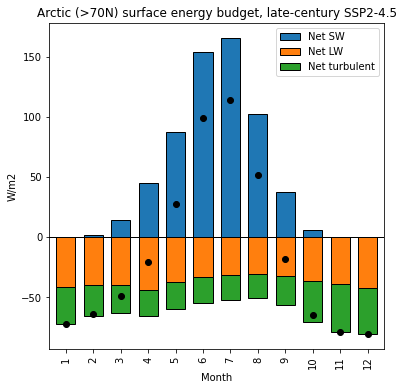

In [10]:

#ds = ds_ssp245.copy()

def plot_surface_energy_budget(ds, title):
    SW = ds.rsds - ds.rsus
    LW = ds.rlds - ds.rlus
    H = - ds.hfls - ds.hfss
    
    df = pd.DataFrame({'Month':ds.month.values,
                       'Net SW':SW.values,
                       'Net LW':LW.values,
                       'Net turbulent':H.values,
                       'Total':(SW+LW+H).values}
                     )#.set_index('Month')
    
    fig, ax = plt.subplots(figsize = (6, 6))
    # Plot
    df.drop(columns=['Total']).plot(kind = "bar",
            x='Month',
            stacked = True,
            ax = ax,
            width = 0.7,
            edgecolor = "black")

    ax.axhline(y=0, c='black', lw=1)
    ax.scatter(range(len(df)), df['Total'], c='black')
    ax.set_title(title)
    ax.set_ylabel('W/m2')
    plt.savefig('Figures/NAHT/{}.jpg'.format(title), dpi=400)
    return

plot_surface_energy_budget(ds_ssp245.copy(),
                          'Arctic (>{l}N) surface energy budget, late-century SSP2-4.5'.format(l=min_lat))

In [ ]:
plot_surface_energy_budget(ds_arise, 'x')

In [ ]:
plot_surface_energy_budget(ds_ssp585 - ds_ssp245, 
                          'Arctic (>{l}N) surface energy budget anomaly,\n SSP5-8.5 - SSP2-4.5, 2080-2100'.format(l=min_lat))

In [ ]:
plot_surface_energy_budget(ds_g6sulfur - ds_ssp585,
                          'Arctic (>{l}N) surface energy budget anomaly,\n G6solar - SSP2-4.5, 2080-2100'.format(l=min_lat))

In [ ]:
plot_surface_energy_budget(ds_g6sulfur - ds_ssp245,
                          'Arctic (>{l}N) surface energy budget anomaly,\n G6sulfur - SSP2-4.5, 2080-2100'.format(l=min_lat))

In [ ]:
plot_surface_energy_budget(ds_g6sulfur - ds_g6solar,
                          'Arctic (>{l}N) surface energy budget anomaly,\n G6sulfur - G6solar, 2080-2100'.format(l=min_lat))

In [ ]:
plot_surface_energy_budget(ds_arise - ds_ssp245,
                          'Arctic (>{l}N) surface energy budget anomaly,\n G6sulfur - G6solar, 2080-2100'.format(l=min_lat))

In [ ]:
ds_dict = {'SSP5-8.5 - SSP2-4.5': ds_ssp585 - ds_ssp245,
           'G6sulfur - SSP2-4.5': ds_g6sulfur - ds_ssp245,
           'G6solar - SSP2-4.5': ds_g6solar - ds_ssp245,
           'G6sulfur - G6solar': ds_g6sulfur - ds_g6solar,
           
          }
    
    
fig, axs = plt.subplots(1, len(ds_dict), figsize = (16, 6), sharey=True)

add_tas = True
    
i=0
for title in ds_dict:
    ds = ds_dict[title]
    ax = axs[i]
    SW = ds.rsds - ds.rsus
    LW = ds.rlds - ds.rlus
    H = - ds.hfls - ds.hfss
    
    df = pd.DataFrame({'Month':ds.month.values,
                       'Net SW':SW.values,
                       'Net LW':LW.values,
                       'Net turbulent':H.values,
                       'Total':(SW+LW+H).values,
                       'tas':ds.tas.values}
                     )#.set_index('Month')
    mean = df['Total'].mean()
    
    df.drop(columns=['Total', 'tas']).plot(kind = "bar",
            x='Month',
            stacked = True,
            ax = ax,
            width = 0.7,
            edgecolor = "black")
    
    ax.scatter(range(len(df)), df['Total'], c='black')
    
    ax.set_title(title)
    ax.set_ylabel('W/m2')
    ax.axhline(y=0, c='black', lw=1)
    ax.axhline(y=mean, c='black', lw=1, ls='--')

    if add_tas:
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'red'
        if i==3:
            ax2.set_ylabel('tas °C', color=color)  # we already handled the x-label with ax1
        ax2.plot(range(len(df)), df['tas'], c=color, ls='--')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_ylim(-1, 9)
        align.yaxes(ax, 0, ax2, 0, 0.3)
    
    #ax2.legend()

    if i > 0:
        ax.get_legend().remove()
    i=i+1
plt.tight_layout()
plt.savefig('Figures/NAHT/all_surface_heat_fluxes.jpg', dpi=400)

In [ ]:
# same, but as a pertubation from the background scen
ds_dict = {
           'G6sulfur - SSP5-8.5': ds_g6sulfur - ds_ssp585,
           'G6solar - SSP5-8.5': ds_g6solar - ds_ssp585,
           #'G6sulfur - G6solar': ds_g6sulfur - ds_g6solar,
           'ARISE - SSP2-4.5': ds_arise - ds_ssp245
          }
    
    
fig, axs = plt.subplots(1, len(ds_dict), figsize = (16, 6), sharey=True)

add_tas = True
    
i=0
for title in ds_dict:
    ds = ds_dict[title]
    ax = axs[i]
    SW = ds.rsds - ds.rsus
    LW = ds.rlds - ds.rlus
    H = - ds.hfls - ds.hfss
    
    df = pd.DataFrame({'Month':ds.month.values,
                       'Net SW':SW.values,
                       'Net LW':LW.values,
                       'Net turbulent':H.values,
                       'Total':(SW+LW+H).values,
                       'tas':ds.tas.values}
                     )#.set_index('Month')
    mean = df['Total'].mean()
    
    df.drop(columns=['Total', 'tas']).plot(kind = "bar",
            x='Month',
            stacked = True,
            ax = ax,
            width = 0.7,
            edgecolor = "black")
    
    ax.scatter(range(len(df)), df['Total'], c='black')
    
    ax.set_title(title)
    ax.set_ylabel('W/m2')
    ax.axhline(y=0, c='black', lw=1)
    ax.axhline(y=mean, c='black', lw=1, ls='--')
    ax.set_ylim(-25, 20)

    if add_tas:
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'red'
        if i==3:
            ax2.set_ylabel('tas °C', color=color)  # we already handled the x-label with ax1
        ax2.plot(range(len(df)), df['tas'], c=color, ls='--')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_ylim(-6, 9)
        align.yaxes(ax, 0, ax2, 0, 0.3)
    
    #ax2.legend()

    if i > 0:
        ax.get_legend().remove()
    i=i+1
plt.tight_layout()
plt.savefig('Figures/NAHT/all_surface_heat_fluxes_pert.jpg', dpi=400)

In [ ]:
# same, but with SW split out into up and down
ds_dict = {'SSP2-4.5':ds_ssp245,
           'G6sulfur - SSP5-8.5': ds_g6sulfur - ds_ssp585,
           'G6solar - SSP5-8.5': ds_g6solar - ds_ssp585,
           #'G6sulfur - G6solar': ds_g6sulfur - ds_g6solar,
           'ARISE - SSP2-4.5': ds_arise - ds_ssp245
          }
    
    
fig, axs = plt.subplots(1, len(ds_dict), figsize = (16, 6), sharey=False)

add_tas = True
    
i=0
for title in ds_dict:
    ds = ds_dict[title]
    ax = axs[i]
    SWd = ds.rsds
    SWu = -ds.rsus
    SW = ds.rsds - ds.rsus
    LW = ds.rlds - ds.rlus
    H = - ds.hfls - ds.hfss
    
    df = pd.DataFrame({'Month':ds.month.values,
                       'SWd':SWd.values,
                       'SWu':SWu.values,
                       'Net LW':LW.values,
                       'Net turbulent':H.values,
                       'Total':(SW+LW+H).values,
                       'tas':ds.tas.values}
                     )#.set_index('Month')
    mean = df['Total'].mean()
    
    df.drop(columns=['Total', 'tas']).plot(kind = "bar",
            x='Month',
            stacked = True,
            ax = ax,
            width = 0.7,
            edgecolor = "black")
    
    ax.scatter(range(len(df)), df['Total'], c='black')
    
    ax.set_title(title)
    ax.set_ylabel('W/m2')
    ax.axhline(y=0, c='black', lw=1)
    ax.axhline(y=mean, c='black', lw=1, ls='--')
    #ax.set_ylim(-25, 20)

    if add_tas:
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'red'
        if i==3:
            ax2.set_ylabel('tas °C', color=color)  # we already handled the x-label with ax1
        ax2.plot(range(len(df)), df['tas'], c=color, ls='--')
        ax2.tick_params(axis='y', labelcolor=color)
        #ax2.set_ylim(-6, 9)
        align.yaxes(ax, 0, ax2, 0, 0.3)
    
    #ax2.legend()

    if i > 0:
        ax.get_legend().remove()
    i=i+1
plt.tight_layout()
plt.savefig('Figures/NAHT/all_surface_heat_fluxes_pert.jpg', dpi=400)

### Atmospheric heat Transport

Define a quantity, Q, as the residual from all energy budget terms above, for the pan-Arctic atmospheric column.

Q is equal to the sum of (1) AHT across boundary, and (2) change in energy stored in atmospheric column. 

or in my notation:

Q = AHT + d(S)/dt 

where S is the atmospheric stored energy, is equal to the integral over pressure levels of delta(cT + Lq)

In [ ]:

# take Q as sum of energy leaving air column 
def get_Q(ds, units='W/m2'):
    
    if not units in ['W/m2', 'PW']: #check units
        print('Units must be set to either "W/m2" or "PW", default is W/m2') 
        
    ds = ds.mean('month')
    Q = (ds.rsds - ds.rsus + ds.rlds - ds.rlus - ds.hfls - ds.hfss + ds.rsut - ds.rsdt + ds.rlut)
   
    ### need to multiply by area to get these into total AHT units (PW)
    area = get_surface_area_north_of_lat(min_lat)
    unit_conversions = {'W/m2':1,
                        'PW':area/(10**15)}
    ### now split into moist and dry components. Done following Hahn et al. 2021
    ### https://www.frontiersin.org/articles/10.3389/feart.2021.710036/full
    ### we take moist energy transport as (P-E)*(latent heat of vaporisation).
    ### this neglects the latent heat of fusion for solid precip. 
    ### the dry component is then calculated as the difference between Q and moist

    L = 2.501*(10**6)# latent heat of vaporisation, assumed constant at 2.501 × 10^6 J kg−1
    Qmoist = (ds.pr - ds.evspsbl)*L 

    Q = Q*unit_conversions[units] 
    Qmoist = Qmoist*unit_conversions[units]
        
    Qdry = Q - Qmoist
    return {'Q':Q.values*1, 'Qdry':Qdry.values*1, 'Qmoist':Qmoist.values*1}

def get_monthlyQ(ds, units='W/m2'):

    if not units in ['W/m2', 'PW']: #check units
        print('Units must be set to either "W/m2" or "PW", default is W/m2') 
    
    ### need to multiply by area to get these into total AHT units (PW)
    area = get_surface_area_north_of_lat(min_lat)
    unit_conversions = {'W/m2':1,
                        'PW':area/(10**15)}
    ds['Q'] = (ds.rsds - ds.rsus + ds.rlds - ds.rlus - ds.hfls - ds.hfss + ds.rsut - ds.rsdt + ds.rlut)*unit_conversions[units] #in PW

    ### now split into moist and dry components. Done following Hahn et al. 2021
    ### https://www.frontiersin.org/articles/10.3389/feart.2021.710036/full
    ### we take moist energy transport as (P-E)*(latent heat of vaporisation).
    ### this neglects the latent heat of fusion for solid precip. 
    ### the dry component is then calculated as the difference between Q and moist

    L = 2.501*(10**6)# latent heat of vaporisation, assumed constant at 2.501 × 10^6 J kg−1
    ds['Qmoist'] = (ds.pr - ds.evspsbl)*L*unit_conversions[units] 
    ds['Qdry'] = ds['Q'] - ds['Qmoist']
    return ds

units = 'W/m2'

# add heat transport to ds's
Q_ssp245 = get_Q(ds_ssp245, units=units)
deltaQ_g6sulfur = get_Q(ds_g6sulfur - ds_ssp245, units=units)
deltaQ_g6solar = get_Q(ds_g6solar - ds_ssp245, units=units)
deltaQ_ssp585 = get_Q(ds_ssp585 - ds_ssp245, units=units)

ds_ssp245 = get_monthlyQ(ds_ssp245, units=units)    
ds_ssp585 = get_monthlyQ(ds_ssp585, units=units)    
ds_g6sulfur = get_monthlyQ(ds_g6sulfur, units=units)    
ds_g6solar = get_monthlyQ(ds_g6solar, units=units)    

In [ ]:
Q_ssp245

In [ ]:
ds_ssp245

In [ ]:
def plot_AHT_monthly(ds, title, units):
    
    df = pd.DataFrame({'Month':ds.month.values,
                       'Total AHT':ds.Q.values,
                       'Sensible AHT':ds.Qdry.values,
                       'Latent AHT':ds.Qmoist.values,
                       }
                     )#.set_index('Month')
    
    fig, ax = plt.subplots(figsize = (6, 6))
    # Plot
    df.drop(columns=['Total AHT']).plot(kind = "bar",
            x='Month',
            stacked = True,
            ax = ax,
            width = 0.7,
            edgecolor = "black")
    
    ax.scatter(range(len(df)), df['Total AHT'], c='black')
    ax.set_title(title)
    ax.set_ylabel(units)
    ax.axhline(y=0, c='black', lw=1)
    return



In [ ]:
plot_AHT_monthly(ds_ssp245, 'AHT into Arctic under SSP245, end century', units=units)
#plot_AHT_monthly(ds_ssp585-ds_ssp245, 'AHT into Arctic anomaly SSP585 - SSP245, end century', units=units)
#plot_AHT_monthly(ds_g6sulfur-ds_ssp245, 'AHT into Arctic anomaly G6sulfur - SSP245, end century', units=units)
#plot_AHT_monthly(ds_g6solar-ds_ssp245, 'AHT into Arctic anomaly G6solar - SSP245, end century', units=units)
#plot_AHT_monthly(ds_g6sulfur-ds_g6solar, 'AHT into Arctic anomaly G6sulfur - g6solar, end century', units=units)

### Now combine into some nice figures:

In [ ]:
ds_dict = {'SSP5-8.5 - SSP2-4.5': ds_ssp585 - ds_ssp245,
           'G6sulfur - SSP2-4.5': ds_g6sulfur - ds_ssp245,
           'G6solar - SSP2-4.5': ds_g6solar - ds_ssp245,
           'G6sulfur - G6solar': ds_g6sulfur - ds_g6solar,
          }
    
    
fig, axs = plt.subplots(1, len(ds_dict), figsize = (16, 6), sharey=True)
    
i=0
for title in ds_dict:
    ds = ds_dict[title]
    ax = axs[i]
    df = pd.DataFrame({'Month':ds.month.values,
                       'tas':ds.tas.values,
                   'Total AHT':ds.Q.values,
                   'Sensible AHT':ds.Qdry.values,
                   'Latent AHT':ds.Qmoist.values,
                   }
                 )#.set_index('Month')
    mean = df['Total AHT'].mean()
    df.drop(columns=['Total AHT', 'tas']).plot(kind = "bar",
            x='Month',
            stacked = True,
            ax = ax,
            width = 0.7,
            edgecolor = "black")
    
    ax.scatter(range(len(df)), df['Total AHT'], c='black')
    #ax.plot(range(len(df)), df['tas'], c='red', ls='--')
    ax.set_title(title)
    ax.set_ylabel(units)
    ax.axhline(y=0, c='black', lw=1)
    ax.axhline(y=mean, c='black', lw=1, ls='--')
    if i > 0:
        ax.get_legend().remove()
    i=i+1
plt.savefig('Figures/NAHT/all_AHT.jpg', dpi=400)

In [ ]:
######### now take a look at ocean heat transport


## example:
dirs_hfb_G6sulf =  get_dirs(var='hfbasin', model=model, scenario='G6sulfur', table='Omon') 
ds_hfb_G6sulf = read_in_ens_mean(dirs_hfb_G6sulf)
ds_hfb_G6sulf = ds_hfb_G6sulf.sel(basin=0) #0 for atlantic/arctic
print(ds_hfb_G6sulf.sector.values) #check we have the right basin
ds_hfb_G6sulf.hfbasin.mean(dim='time').plot()

In [ ]:
def add_hfbasin(ds_in, model=model, scen='G6sulfur', lats=[60, 66, 70], verbose=False):
    
    """ adds atlantic heat transport (hfbasin with basin=0) to
    the ds_in, for a selection of latitudes """
    
    dirs_hfb = get_dirs(var='hfbasin', model=model, scenario=scen, table='Omon')
    ds_hfb = read_in_ens_mean(dirs_hfb)
    ds_hfb = ds_hfb.sel(basin=0) #0 for atlantic/arctic
    if verbose:
        print('Selected ocean basin: ', ds_hfb.sector.values) #check we have the right basin
    dss = []
    for lat in lats:
        sel_method = 'nearest'
        da = ds_hfb.sel(y=lat, method=sel_method).hfbasin
        area = get_surface_area_north_of_lat(da.y.values)
        da = da/area
        if verbose:
            print('target y:', str(lat))
            print('selected y ({}): '.format(sel_method), str(da.y.values))
        ds_lat = da.to_dataset(name='hfAtl_{}'.format(str(lat)))
        ds_lat = ds_lat.sel(time=slice(min_year_late_cent, max_year_late_cent)).groupby("time.month").mean(dim="time").drop('y')
        dss.append(ds_lat)
    ds_lats = xr.merge(dss)
    ds_out = xr.merge([ds_in, ds_lats])
    return ds_out

In [ ]:
### now run over scenarios

ds_g6sulfur = add_hfbasin(ds_g6sulfur, scen='G6sulfur', verbose=True)
ds_g6solar = add_hfbasin(ds_g6solar, scen='G6solar')
ds_ssp585 = add_hfbasin(ds_ssp585, scen='ssp585')
ds_ssp245 = add_hfbasin(ds_ssp245, scen='ssp245')

In [ ]:
ds_dict = {'SSP5-8.5 - SSP2-4.5': ds_ssp585 - ds_ssp245,
           'G6sulfur - SSP2-4.5': ds_g6sulfur - ds_ssp245,
           'G6solar - SSP2-4.5': ds_g6solar - ds_ssp245,
           'G6sulfur - G6solar': ds_g6sulfur - ds_g6solar,
          }
    
    
fig, axs = plt.subplots(1, len(ds_dict), figsize = (16, 6), sharey=True)
    
i=0
for title in ds_dict:
    ds = ds_dict[title]
    ax = axs[i]
    df = pd.DataFrame({'Month':ds.month.values,
                       'tas':ds.tas.values,
                   'Total HT':ds.Q.values + ds.hfAtl_66.values,
                   'Sensible AHT':ds.Qdry.values,
                   'Latent AHT':ds.Qmoist.values,
                   'OHT':ds.hfAtl_66.values 
                   }
                 )#.set_index('Month')
    mean = df['Total HT'].mean()
    df.drop(columns=['Total HT', 'tas']).plot(kind = "bar",
            x='Month',
            stacked = True,
            ax = ax,
            width = 0.7,
            edgecolor = "black")
    
    ax.scatter(range(len(df)), df['Total HT'], c='black')
    #ax.plot(range(len(df)), df['tas'], c='red', ls='--')
    ax.set_title(title)
    ax.set_ylabel(units)
    ax.axhline(y=0, c='black', lw=1)
    ax.axhline(y=mean, c='black', lw=1, ls='--')
    if i > 0:
        ax.get_legend().remove()
    i=i+1
plt.savefig('Figures/NAHT/all_HT.jpg', dpi=400)